In [1]:
# Import the Format and Analyze classes from the utilities.cal_utils module
from utlities.cal_utils import Format
from utlities.cal_utils import Analyze
from utlities.cal_utils import Graph

# Import various necessary libraries and modules
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting library
import matplotlib.gridspec as gridspec  # Grid layout for subplots
import matplotlib.ticker as ticker  # Import ticker module for custom tick formatting

import seaborn as sns  # Statistical data visualization
import math  # Mathematical functions
import scipy  # Scientific and technical computing
from scipy.signal import find_peaks  # Function to find peaks in data
import numpy as np  # Numerical computing
import os  # Miscellaneous operating system interfaces
from math import log10, floor

from scipy.signal import iirfilter
import numpy as np


# Define a representation string
rep = "3"

# Paths to data and metadata excel files, using f-strings for dynamic paths
path_data = f"./Data/rep{rep}_data.xlsx"
path_md = f"./Data/rep{rep}_md.xlsx"

# Define folder paths for outputs and graph options using f-strings
folder = f"./picker_outputs_rep{rep}"
option_graphs_folder_for_11mm = f"rep{rep}_11mM_option_graphs"
complete_graphs = f"rep{rep}_11mM_complete__graphs"

# Create Format object for data formatting, passing the data path
form = Format(path = path_data)
# Create Analyze object for data analysis
analyze = Analyze()
graph = Graph()

# Set the Seaborn style to "darkgrid" for better graph visibility
sns.set_style("darkgrid")
# Set Seaborn color palette to 'colorblind' mode for accessibility
sns.color_palette('colorblind')


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [2]:
# Check if the specified folder does not exist
if not os.path.exists(folder):
    # If the specified directory (folder) is not present, then create it.
    # This is useful for ensuring the existence of a directory before trying to save files to it,
    # preventing errors related to attempting to access or write to a non-existent directory.
    os.makedirs(folder)


In [3]:
"""df = form.tidy_file(delta = False, average = True, baseline = 30, errors= False)
df.to_csv(f'{folder}/Rep{rep}_df.csv', index=False)"""

"df = form.tidy_file(delta = False, average = True, baseline = 30, errors= False)\ndf.to_csv(f'{folder}/Rep{rep}_df.csv', index=False)"

In [4]:
"""This cell makes the original data for this rep tidy,  calculated the normalized AU, and saves it to an exterior excel file"""

# perform normalization of arbitrary units (AU), and save the results to an external Excel file.

# Check if the specified CSV file does not already exist in the folder for this specific repetition.
if not os.path.exists(f'{folder}/Rep{rep}_df.csv'):
    # Call the tidy_file method from the form object (which is an instance of the Format class),
    # passing parameters to control the data tidying process:
    # - delta: False indicates that the delta transformation should not be applied.
    # - average: True indicates that averaging of data should be performed.
    # - baseline: 40 specifies the timeframe to use for normalization
    # The tidy_file method returns a pandas DataFrame that has been cleaned and processed based on the specified parameters.
    df = form.tidy_file(delta = False, average = True, baseline = 40)
    
    # Save the processed DataFrame to a CSV file in the specified folder.
    # The file is named based on the repetition number (rep) to distinguish it from other repetitions' data.
    # index=False parameter is used to prevent pandas from writing row indices into the CSV file.
    df.to_csv(f'{folder}/Rep{rep}_df.csv', index=False)


In [5]:
"""df_complete = df.copy()
df = df[df["Normalized A.U."] != "DIV/0!"]"""

'df_complete = df.copy()\ndf = df[df["Normalized A.U."] != "DIV/0!"]'

In [6]:
#df[(df["Treatment"]== "NoRTG Inh - Islet 3") & (df["Cell #"] == "Cell 24")]

In [7]:


#print(f"{len(complete_df["Cell #"].unique()) - len(df["Cell #"].unique())} cells were removed for normilization errors")

In [8]:
"""df1 = df["Treatment"] + df["Cell #"]
df2 = df_complete["Treatment"] + df_complete["Cell #"]

len(df2.unique()) - len(df1.unique())"""

'df1 = df["Treatment"] + df["Cell #"]\ndf2 = df_complete["Treatment"] + df_complete["Cell #"]\n\nlen(df2.unique()) - len(df1.unique())'

In [9]:
"""df[(df["Treatment"] == "10wt% RTG NoInh - Islet 3") & (df["Cell #"] == "Cell 23")]"""

'df[(df["Treatment"] == "10wt% RTG NoInh - Islet 3") & (df["Cell #"] == "Cell 23")]'

In [10]:
#load the first exel file in tidy format
df = pd.read_csv(f'{folder}/Rep{rep}_df.csv')

#the start times selected by chelsea and the end times selected by me
md = pd.read_excel(path_md)


In [11]:
#remove all columns from df that contain the error message in the normalized column

In [12]:
if not os.path.exists(f'{folder}/rep{rep}_option__graphs'): 
      
    # if the demo_folder directory is not present  
    # then create it. 
                      
    os.makedirs(f'{folder}/rep{rep}_option__graphs')

In [13]:
# Find all unique treatments in the DataFrame
treatments = df.Treatment.unique()
# Set the Seaborn style to "whitegrid" with dashed grid lines for better visibility
sns.set_style("whitegrid", {'grid.linestyle': '--'})

# Initialize an empty list to store data for each cell
dfs = []

# Iterate through each unique treatment
for n, treat in enumerate(treatments):

    # Skip treatments that include "Inh" in their name
    if " Inh " in treat:
        continue

    # Filter the DataFrame for the current treatment
    temp_df = df[df["Treatment"] == treat]
    # Filter the metadata DataFrame for the current treatment
    temp_md = md[md["Treatment"] == treat]

    # Find all unique cell numbers for the current treatment
    cells = temp_df["Cell #"].unique()

    # Generate a color palette for the cells
    palette = sns.color_palette("colorblind", len(cells))

    # Create a new figure with subplots, one for each cell
    plt.figure(figsize=(15, int(10*len(cells))))
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle(f"Rep {rep}: {treat}", fontsize=15, y=0.9)

    # Iterate through each cell
    for m, cell in enumerate(cells):
        
        # Find the start and end time for the stimulus window from the metadata
        wind_start = temp_md["11 mM Stimulus"].iloc[0]
        wind_end = temp_md["20 mM Stimulus"].iloc[0]
        # Filter the data for the current cell and time window
        plot_df = temp_df[temp_df["Cell #"] == cell]
        plot_df = plot_df[plot_df["Time (sec)"].between(wind_start, wind_end)]

        # Apply a Butterworth filter to smooth the data
        plot_df = analyze.apply_butterworth_filter(plot_df, mode = "smooth")

        # Create a subplot for the current cell
        col_num = 1
        ax = plt.subplot(int(math.ceil(len(cells)/col_num)), col_num, m + 1)

        # Set the x and y-axis labels
        ax.set_xlabel("Time (sec)")
        ax.set_ylabel("A.U.")

        # Plot the original and smoothed data
        sns.lineplot(data = plot_df, x = "Time (sec)", y = "Normalized A.U.", color=palette[m], alpha = 0.9)
        sns.lineplot(data = plot_df, x = "Time (sec)", y = "Smoothed Normalized A.U.", color=palette[m], alpha = 0.6)

        # Find and mark the minima
        inverted_signal = -plot_df["Smoothed Normalized A.U."].values
        min_locations = find_peaks(inverted_signal)[0]  # Add any additional parameters as needed
 
        graph.mark_locations(ax, plot_df, min_locations, 'dot', 'green')  # Mark minima with green dots

        # Find and mark the maxima, limiting to the first 3
        max_locations = find_peaks(plot_df["Smoothed Normalized A.U."], distance=10, height=5, prominence=0.1)[0][:3]

        # Mark the plot with minima and maxima and update metadata
        cell_md_cop = graph.mark_plot_and_update_ends(plot_df, min_locations, max_locations, temp_md, cell, ax)
   
        # Add the updated metadata for the cell to the list
        dfs.append(cell_md_cop)

        # Configure the plot ticks for readability
        graph.configure_plot_ticks(ax, plot_df, False, 20)

        # Set the font size for the axis labels
        ax.set_xlabel("Time (sec)", fontsize=12)
        ax.set_ylabel("A.U.", fontsize=12)
        # Set the title for the subplot
        ax.set_title(f"{treat.upper()} \n {cell}")
        
    # Save the figure to a file and close it to free memory
    plt.savefig(f"{folder}/rep{rep}_option__graphs/Rep{rep}_{treat}_graphs.png", bbox_inches = "tight")
    plt.close();

# Concatenate all the updated metadata DataFrames
new_md = pd.concat(dfs)
# Add empty columns for quality, end time, and notes
new_md["Quality"] = ""
new_md["11 mM End"] = ""
new_md["Notes"] = ""
    
# Save the updated metadata to an Excel file
new_md.to_excel(f"{folder}/rep{rep}_dd.xlsx")


In [14]:
if not os.path.exists(f'{folder}/{complete_graphs}'): 
      
    # if the demo_folder directory is not present then create it
                      
    os.makedirs(f'{folder}/{complete_graphs}')

In [15]:
# Unique treatments are extracted from the 'Treatment' column of the df DataFrame.
treatments = df.Treatment.unique()
# Set the Seaborn style to "whitegrid" with dashed grid lines for improved readability of plots.
sns.set_style("whitegrid", {'grid.linestyle': '--'})

# Iterate over each unique treatment using enumerate to also get the loop index.
for n, treat in enumerate(treatments):
    # Filter the main DataFrame and metadata DataFrame for the current treatment.
    temp_df = df[df["Treatment"] == treat]
    temp_md = md[md["Treatment"] == treat]

    # Extract unique cell identifiers for the current treatment.
    cells = temp_df["Cell #"].unique()

    # Initialize the color palette based on the number of cells to ensure distinct colors.
    palette = sns.color_palette("colorblind", len(cells))

    # Set up the figure with a dynamic height based on the number of cells.
    plt.figure(figsize=(15, int(10*len(cells))))
    plt.subplots_adjust(hspace=0.4)  # Adjust space between plots.
    plt.suptitle(f"Rep {rep}: {treat}", fontsize=15, y=0.887)  # Title for the collection of plots.

    # Iterate over each cell to plot individual cell data.
    for m, cell in enumerate(cells):
        # Filter the DataFrame for the current cell.
        plot_df = temp_df[temp_df["Cell #"] == cell]

        col_num = 1  # Column number for subplot layout, can be adjusted for a different layout.
        ax = plt.subplot(int(math.ceil(len(cells)/col_num)), col_num, m + 1)  # Create a subplot for each cell.

        # Check for the absence of metadata.
        if len(temp_md) == 0:
            print(f"There is no metadata on {treat} so no starts or ends of curves are unknown")
            continue  # Skip the current iteration if metadata is missing.

        # If metadata exists, draw vertical lines for stimulus start times and label them.
        ax.axvline(x=temp_md["11 mM Stimulus"].iloc[0], color='grey')
        ax.axvline(x=temp_md["20 mM Stimulus"].iloc[0], color='grey')
        # Position text labels at the bottom of the graph for stimulus start times.
        y_pos = ax.get_ylim()[0]  # Get the bottom y-axis value for positioning text.
        ax.text(temp_md["11 mM Stimulus"].iloc[0], y_pos, "11mM Start", color='grey', verticalalignment='bottom')
        ax.text(temp_md["20 mM Stimulus"].iloc[0], y_pos, "20mM Start", color='grey', verticalalignment='bottom')

        ax.set_xlabel("Time (sec)")
        ax.set_ylabel("A.U.")

        # Plot the normalized absorbance units (A.U.) over time for each cell.
        sns.lineplot(data=plot_df, x="Time (sec)", y="Normalized A.U.", color=palette[m])

        # Configure plot ticks for readability and aesthetics.
        graph.configure_plot_ticks(ax, plot_df, 20, 10)

        ax.set_xlabel("Time (sec)", fontsize=12)  # Set x-axis label with a specified font size.
        ax.set_ylabel("A.U.", fontsize=12)  # Set y-axis label with a specified font size.
        ax.set_title(f"{treat.upper()} \n {cell}")  # Set subplot title with treatment and cell identifiers.

    # Save the figure with a tight bounding box to ensure all content is included.
    plt.savefig(f"{folder}/{complete_graphs}/rep{rep}_{treat}_graphs.png", bbox_inches = "tight")
    plt.close()  # Close the plot to free up memory.


There is no metadata on NoRTG Inh - Islet 1 so no starts or ends of curves are unknown
There is no metadata on NoRTG Inh - Islet 1 so no starts or ends of curves are unknown
There is no metadata on NoRTG Inh - Islet 1 so no starts or ends of curves are unknown
There is no metadata on NoRTG Inh - Islet 1 so no starts or ends of curves are unknown
There is no metadata on NoRTG Inh - Islet 1 so no starts or ends of curves are unknown
There is no metadata on NoRTG Inh - Islet 1 so no starts or ends of curves are unknown
There is no metadata on NoRTG Inh - Islet 1 so no starts or ends of curves are unknown
There is no metadata on NoRTG Inh - Islet 1 so no starts or ends of curves are unknown
There is no metadata on NoRTG Inh - Islet 1 so no starts or ends of curves are unknown
There is no metadata on NoRTG Inh - Islet 1 so no starts or ends of curves are unknown
There is no metadata on NoRTG Inh - Islet 1 so no starts or ends of curves are unknown
There is no metadata on NoRTG Inh - Islet 1

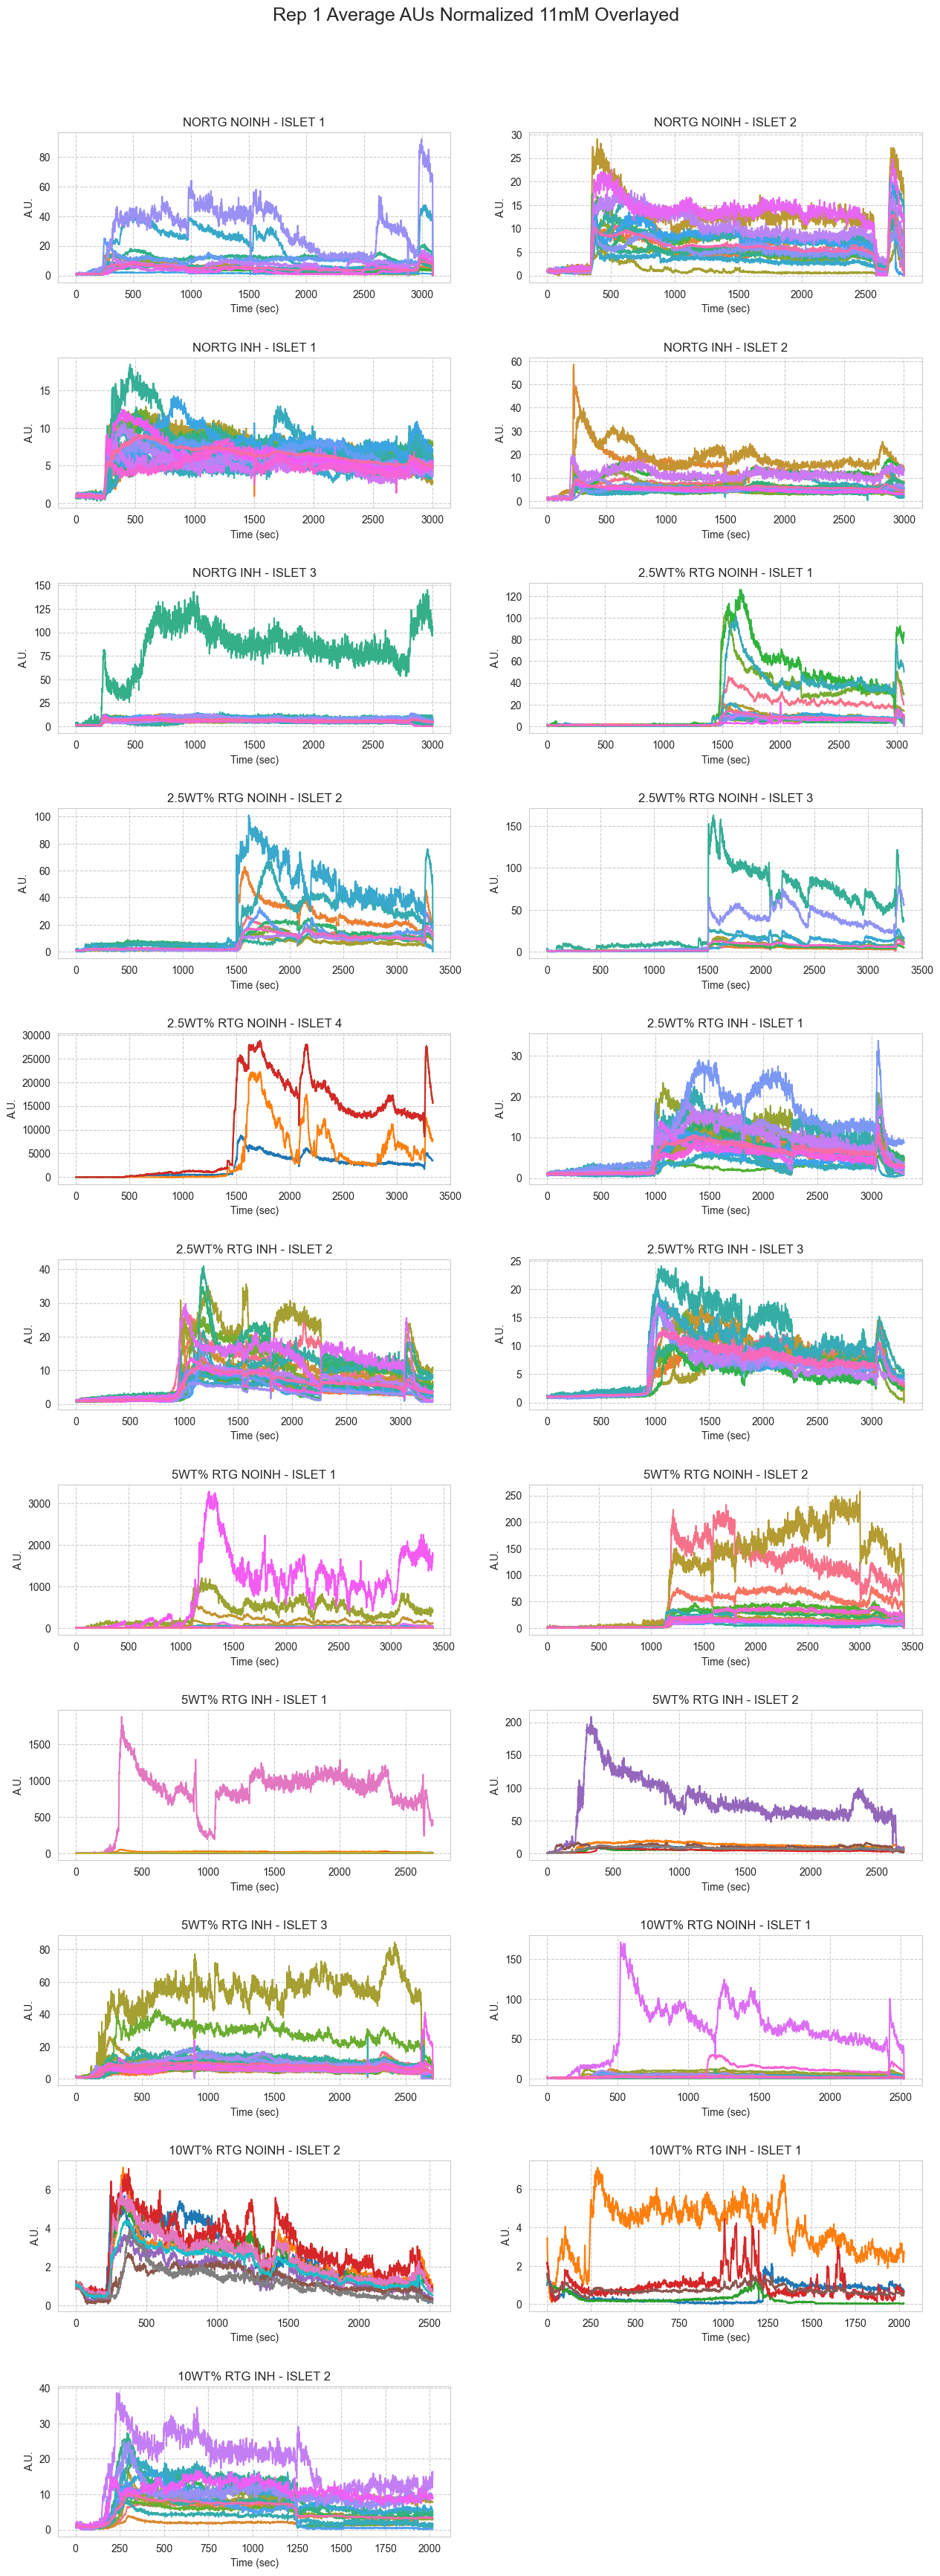

In [16]:
treatments = df.Treatment.unique()

# Set figure size based on the number of treatments, ensuring adequate space for each subplot.
plt.figure(figsize=(15, int(2*len(treatments))))
plt.subplots_adjust(hspace=.5)  # Adjust space between plots for readability.
plt.suptitle("Rep 1 Average AUs Normalized 11mM Overlayed", fontsize=18, y=0.92)  # Title for the entire figure.

# Loop through each unique treatment to create individual subplots.
for n, treat in enumerate(treatments):
    # Create a subplot for each treatment.
    ax = plt.subplot(int(math.ceil(len(treatments)/2)), 2, n + 1)

    # Filter the main DataFrame for the current treatment.
    temp_df = df[df["Treatment"] == treat]
    # Metadata is filtered but not used directly in plotting.
    temp_md = md[md["Treatment"] == treat]

    # Plot data for the current treatment using seaborn's lineplot function.
    # 'Cell #' is used as the hue to differentiate lines for each cell.
    sns.lineplot(data=temp_df, x="Time (sec)", y="Normalized A.U.", hue="Cell #")

    # Set the labels for the x and y axes.
    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("A.U.")

    # Formatting the subplot.
    ax.set_title(treat.upper())  # Use uppercase treatment name for the title.
    ax.get_legend().remove()  # Remove the legend to declutter the plot.

# Save the entire figure as a PNG file, ensuring all elements fit within the borders.
plt.savefig(f"{folder}/Rep{rep}_11mM_curves_overlayed.png", bbox_inches="tight");


Area under the curve was calculated by normalizing the data, subtracting the values of the curve by the starting value, and then using a trapazoid AUC but could easily to rectangular. The error bars depicted are a 95 percent confidence interval but I can change this.